In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from IPython.display import clear_output

tqdm.pandas()
pd.options.display.max_colwidth = -1
pd.options.display.max_columns = 25

In [3]:
from dsutils.eda import *
from dsutils.stats import *
from dsutils.ml import *

In [4]:
import pickle

In [5]:
cv = pickle.load(open('BinaryCountVectorizer.pkl', 'rb'))
tv = pickle.load(open('TfidfVectorizer.pkl', 'rb'))

In [6]:
data = pd.read_csv('fuzzy_features_clean.csv')

In [7]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,abs_token_diff,avg_num_token,rel_token_diff,token_intersection,token_union,jaccard_similarity_token,...,abs_word_diff,avg_num_word,rel_word_diff,word_intersection,word_union,jaccard_similarity_word,lcs_word,lcs_word_ratio,fuzz_simple_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,2,13.0,0.153846,10,13,0.769231,...,1,6.5,0.153846,5,6,0.833333,6,0.923077,92,98,92,100
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0,5,10.5,0.476190,4,16,0.250000,...,5,7.5,0.666667,4,11,0.363636,4,0.533333,64,91,62,89
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0,4,12.0,0.333333,3,21,0.142857,...,1,5.5,0.181818,3,8,0.375000,1,0.181818,66,67,71,85
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0,2,10.0,0.200000,0,19,0.000000,...,4,7.0,0.571429,0,11,0.000000,0,0.000000,44,56,15,19
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0,6,10.0,0.600000,2,18,0.111111,...,5,7.5,0.666667,2,13,0.153846,1,0.133333,52,64,42,53


In [8]:
data.dropna(inplace=True)

In [9]:
from scipy.spatial.distance import hamming, cosine

___
<center><b>Hamming Distance</b></center>

In [10]:
q1_vect = cv.transform(data['q1_clean'])
q2_vect = cv.transform(data['q2_clean'])


         min  1st  25th  50th  75th  99th  max  mean  std
0        0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0
1        0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0
overall  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0


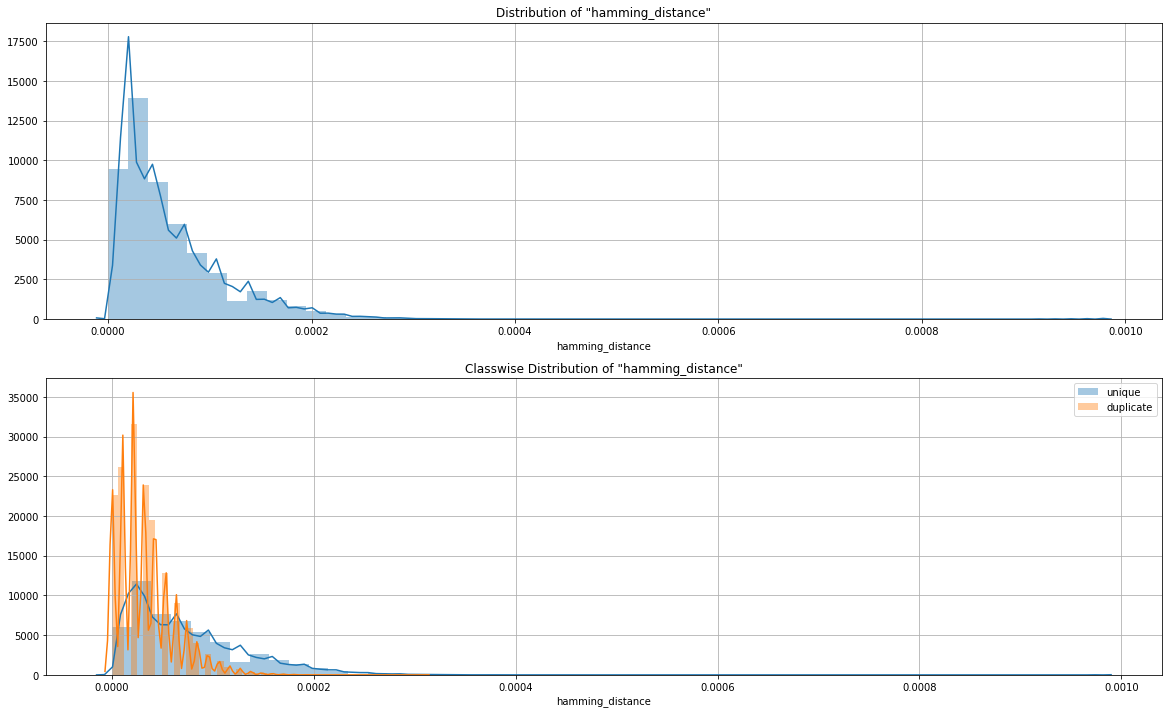

In [11]:
distance = []
for q1, q2 in tqdm(zip(q1_vect, q2_vect)):
    distance.append(hamming(q1.toarray()[0], q2.toarray()[0]))

data['hamming_distance'] = distance

print(feature_distribution(data, 'hamming_distance', 'is_duplicate'))
fig, ax = plot_feature_distribution(data, 'hamming_distance', 'is_duplicate', labels=['unique', 'duplicate'])

___
<center><b>Cosine Distance</b></center>

In [12]:
q1_vect = tv.transform(data['q1_clean'])
q2_vect = tv.transform(data['q2_clean'])


         min  1st  25th  50th  75th  99th  max  mean   std
0       -1.0  0.0  0.28  0.52  0.72  1.00  1.0  0.52  0.29
1       -1.0  0.0  0.11  0.26  0.43  0.76  1.0  0.28  0.20
overall -1.0  0.0  0.20  0.41  0.62  1.00  1.0  0.43  0.28


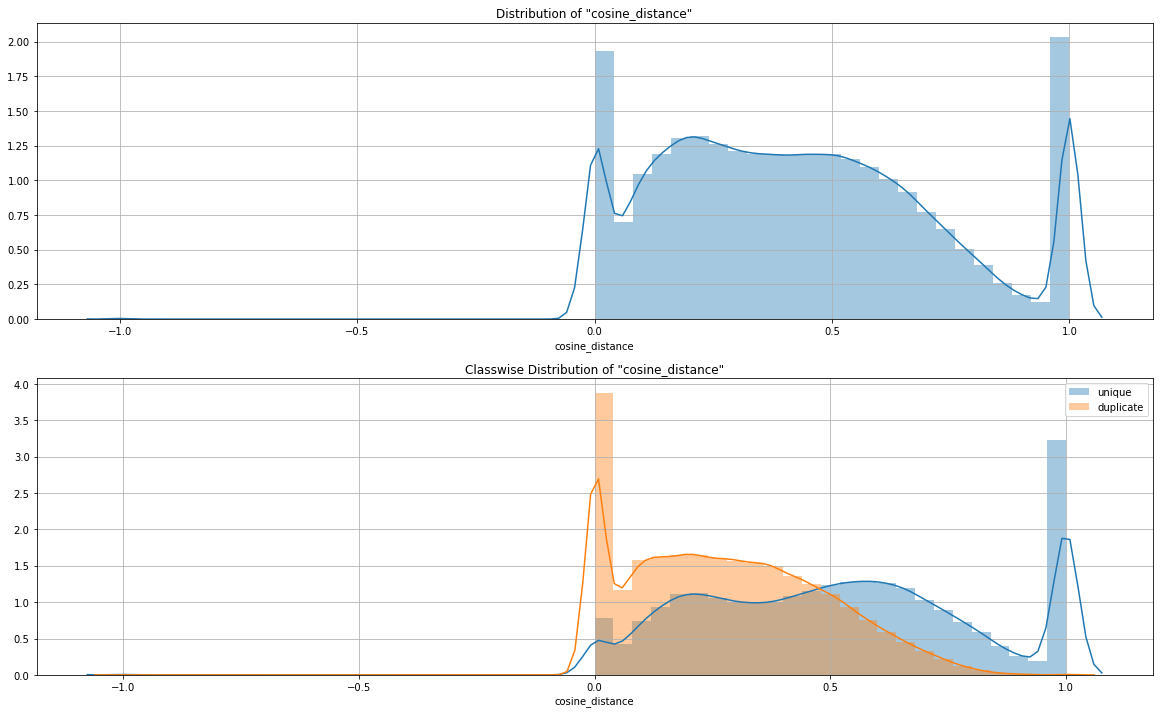

In [13]:
distance = []
for q1, q2 in tqdm(zip(q1_vect, q2_vect)):
    distance.append(cosine(q1.toarray()[0], q2.toarray()[0]))

data['cosine_distance'] = distance
data['cosine_distance'].fillna(-1, inplace=True)
print(feature_distribution(data, 'cosine_distance', 'is_duplicate'))
fig, ax = plot_feature_distribution(data, 'cosine_distance', 'is_duplicate', labels=['unique', 'duplicate'])

In [14]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,abs_token_diff,avg_num_token,rel_token_diff,token_intersection,token_union,jaccard_similarity_token,...,rel_word_diff,word_intersection,word_union,jaccard_similarity_word,lcs_word,lcs_word_ratio,fuzz_simple_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio,hamming_distance,cosine_distance
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,2,13.0,0.153846,10,13,0.769231,...,0.153846,5,6,0.833333,6,0.923077,92,98,92,100,0.000011,0.025243
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0,5,10.5,0.476190,4,16,0.250000,...,0.666667,4,11,0.363636,4,0.533333,64,91,62,89,0.000074,0.233014
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0,4,12.0,0.333333,3,21,0.142857,...,0.181818,3,8,0.375000,1,0.181818,66,67,71,85,0.000053,0.530295
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0,2,10.0,0.200000,0,19,0.000000,...,0.571429,0,11,0.000000,0,0.000000,44,56,15,19,0.000117,1.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0,6,10.0,0.600000,2,18,0.111111,...,0.666667,2,13,0.153846,1,0.133333,52,64,42,53,0.000117,0.764240


In [15]:
feats = ['abs_token_diff', 'avg_num_token', 'rel_token_diff', 
         'token_intersection', 'token_union', 'jaccard_similarity_token',
         'lcs_token', 'lcs_token_ratio',
         'abs_word_diff', 'avg_num_word', 'rel_word_diff',
         'word_intersection', 'word_union', 'jaccard_similarity_word',
         'lcs_word', 'lcs_word_ratio',
         'fuzz_simple_ratio', 'fuzz_partial_ratio', 'fuzz_token_sort_ratio', 'fuzz_token_set_ratio',
         'hamming_distance', 'cosine_distance'
]
pbc = []
for feat in feats:
    pbc.append(point_biserial_correlation('is_duplicate', feat, data))

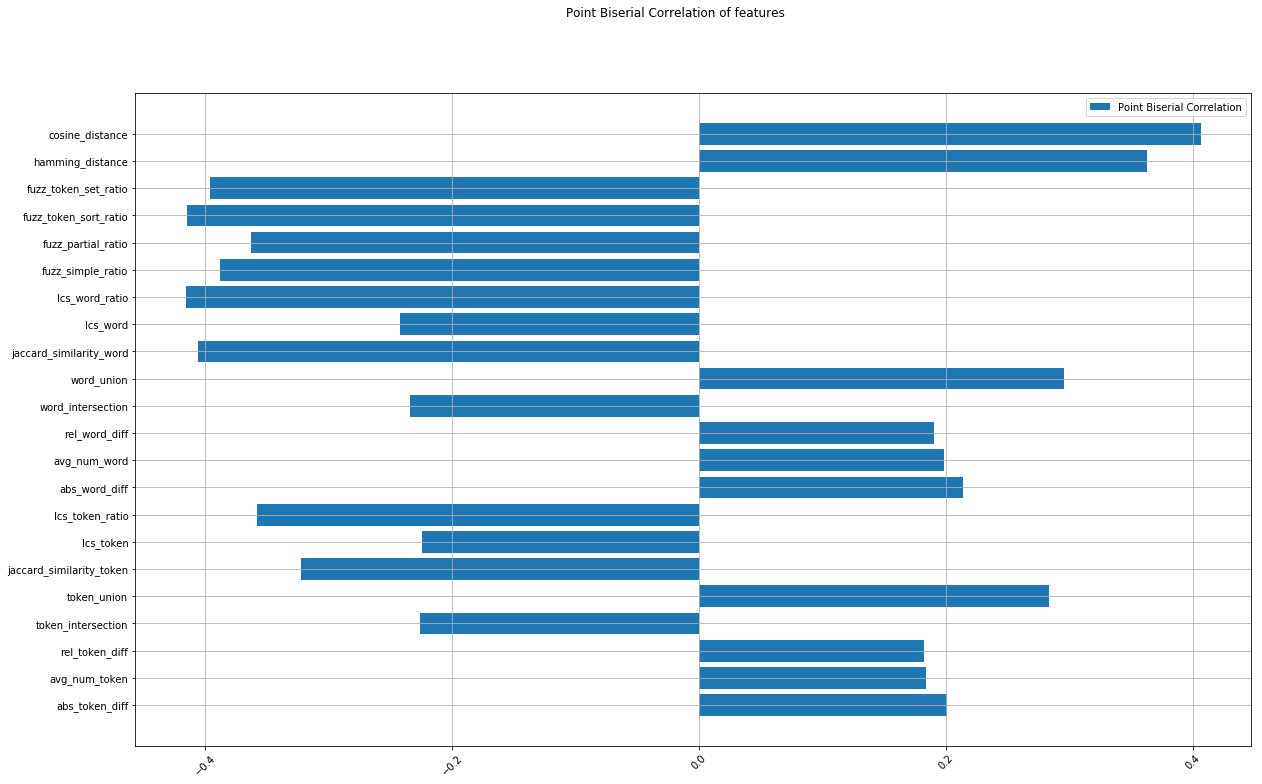

In [16]:
fig, ax = plt.subplots(figsize=(20, 12))
fig.suptitle('Point Biserial Correlation of features')
plt.barh(y=feats, width=pbc)
ax.grid()
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.legend(['Point Biserial Correlation'])

# Model Fitting

In [17]:
from sklearn.linear_model import LogisticRegression

Mean Loss 0.5509987243104835 +- 0.0017849181172392584


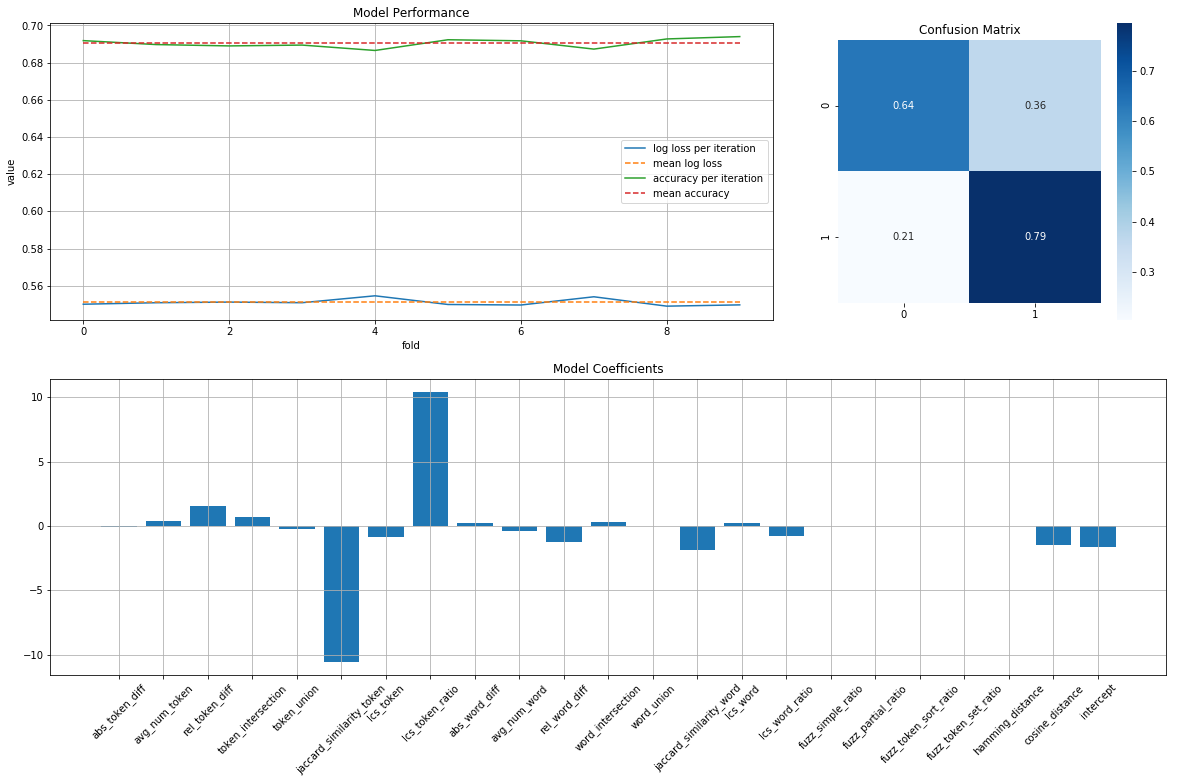

In [18]:
model = LogisticRegression(class_weight='balanced')
lr_performance, lr_cm, lr_model = train_model_lr(model, data, feats, 'is_duplicate')
print('Mean Loss', np.mean(lr_performance['log loss']), '+-', np.std(lr_performance['log loss']))

In [19]:
data.to_csv('advanced_features.csv', index=False)